In [89]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import random
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sn

## Iperparametri

In [90]:
#general
logLabel = "log44"
print_period = 10
use_dummies_input = True

#regularizzation
use_batchnorm = False
use_dropout = True
input_dropout_rate = 0.3
dropout_rate = 0.5

#layer size
use_direct_inputs = True
use_layer_regression_full = True
use_layer_regression_couple = True
n_input_regressions = [30, 10]
n_hiddens = [100]
n_output = 7
activation_function = tf.nn.relu

#training
learning_rate = 0.0001
batch_size = 50
test_batch_size = 30
epochs = 1000
patience = 100
min_delta = 0.01

## Preelabora i dati

In [91]:
df = pd.read_csv('patterns.csv')
all = df.iloc[:, :].values.astype(np.float32)
A = all[all[:,-1]<70]
B = all[(all[:,-1]>=70)&(all[:,-1]<=83)]
C = all[(all[:,-1]>=84)&(all[:,-1]<=98)] 
D = all[(all[:,-1]>=99)&(all[:,-1]<=113)] 
E = all[(all[:,-1]>=114)&(all[:,-1]<=128)] 
F = all[(all[:,-1]>=129)&(all[:,-1]<=143)] 
G = all[all[:,-1]>143]

#prende solo una parte dei dati della categoria A
A = A[0:330,:]

#crea nuovamente il dataframe dopo aver pre-elaborato i dati
data = np.concatenate((A,B,C,D,E,F,G), axis=0)
np.random.shuffle(data)
df = pd.DataFrame(data=data)

## Ottiene i dati

In [92]:
#df = pd.read_csv('patterns.csv')
#print(df.head(5))
       
#ottiene gli input ed li divide in dummy variables
if use_dummies_input:
    #prende i dati in formato dummies e li concatena
    X1 = pd.get_dummies(df.iloc[:, 0]).values.astype(np.float32)
    X2 = pd.get_dummies(df.iloc[:, 24]).values.astype(np.float32)
    for i in range(1,24):
        X1_dummy = pd.get_dummies(df.iloc[:, i]).values.astype(np.float32)
        X2_dummy = pd.get_dummies(df.iloc[:, i+24]).values.astype(np.float32)
        X1 = np.concatenate((X1, X1_dummy), axis=1)
        X2 = np.concatenate((X2, X2_dummy), axis=1)
else:
    #prende i dati e li ridimensiona
    X1 = df.iloc[:, :24].values.astype(np.float32)
    X2 = df.iloc[:, 24:48].values.astype(np.float32)
    X1 = X1/10
    X2 = X2/10

#funzione di trasformazione in classi
def transformToClass(yr):
    yc = []
    for i in range(len(yr)):
        yi = np.zeros(7)
        if (yr[i]<70):                  yi[0] = 1 #A
        if (yr[i]>=70  and yr[i]<=83) : yi[1] = 1 #B
        if (yr[i]>=84  and yr[i]<=98) : yi[2] = 1 #C
        if (yr[i]>=99  and yr[i]<=113): yi[3] = 1 #D
        if (yr[i]>=114 and yr[i]<=128): yi[4] = 1 #E
        if (yr[i]>=129 and yr[i]<=143): yi[5] = 1 #F
        if (yr[i]>143):                 yi[6] = 1 #G
        yc.append(yi)
    yr = np.array(yc)
    return yr

#funzione che conta gli elementi per ogni classe
def printCountClass(yr):
    print("A: ",len(yr[yr<70]))
    print("B: ",len(yr[(yr>=70)&(yr<=83)]))
    print("C: ",len(yr[(yr>=84)&(yr<=98)]))
    print("D: ",len(yr[(yr>=99)&(yr<=113)]))
    print("E: ",len(yr[(yr>=114)&(yr<=128)]))
    print("F: ",len(yr[(yr>=129)&(yr<=143)]))
    print("G: ",len(yr[yr>143]))

#ottiene gli output e li trasforma in classi    
y = df.iloc[:, -1].values.astype(np.float32)
printCountClass(y)  
y = transformToClass(y)

#separa dati di train da dati di test
test_size=0.33
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=test_size, random_state=42)

A:  330
B:  319
C:  317
D:  334
E:  160
F:  21
G:  5


## Crea il modello

In [93]:
tf.reset_default_graph()

#crea i placeholder di input e output
n_input = X1.shape[1]
x_input1 = tf.placeholder(dtype=tf.float32, shape=[None, n_input], name="X1")
x_input2 = tf.placeholder(dtype=tf.float32, shape=[None, n_input], name="X2")
is_training = tf.placeholder(tf.bool, name="isTraining")
y_target = tf.placeholder(dtype=tf.float32, shape=[None, n_output], name='Y')

input_regressions = []

#crea un unico livello di input, per avere solo un hidden layer denso (da commentare le successive 2 sezioni)
if use_direct_inputs:
    input_regressions.append(x_input1)
    input_regressions.append(x_input2)
    

In [94]:
if use_layer_regression_full:
    #regressioni full
    with tf.variable_scope("regression_full1") as scope:
        layer = tf.layers.dense(x_input1, n_input_regressions[0], activation=activation_function)
        #if use_dropout:
            #layer = tf.layers.dropout(layer, rate=input_dropout_rate, training=is_training)
        
        #crea i livelli hidden di full1
        for i in range(1, len(n_input_regressions)):
            with tf.variable_scope("regression_hidden_full1_"+str(i)) as scope:
                layer = tf.layers.dense(layer, n_input_regressions[i], activation=activation_function)
                #if use_dropout:
                    #layer = tf.layers.dropout(layer, rate=dropout_rate, training=is_training)

        #aggiuge il layer nell'elenco delle input regression
        input_regressions.append(layer)
    
    with tf.variable_scope("regression_full2") as scope:
        layer = tf.layers.dense(x_input2, n_input_regressions[0], activation=activation_function)
        #if use_dropout:
            #layer = tf.layers.dropout(layer, rate=input_dropout_rate, training=is_training)
        
        #crea i livelli hidden di full2
        for i in range(1, len(n_input_regressions)):
            with tf.variable_scope("regression_hidden_full2_"+str(i)) as scope:
                layer = tf.layers.dense(layer, n_input_regressions[i], activation=activation_function)
                #if use_dropout:
                    #layer = tf.layers.dropout(layer, rate=dropout_rate, training=is_training)

        #aggiuge il layer nell'elenco delle input regression
        input_regressions.append(layer)

In [95]:
if use_layer_regression_couple:
    #per ogni coppia di input crea una regressione
    with tf.variable_scope("regression_couple") as scope:    
        for i in range(n_input):
            if use_dummies_input:
                layer_input = tf.concat([x_input1[:, i:i+5+1], x_input2[:, i:i+5+1]], axis=1)
            else:    
                layer_input = tf.concat([x_input1[:, i:i+1], x_input2[:, i:i+1]], axis=1)
            layer = tf.layers.dense(layer_input, n_input_regressions[0], activation=activation_function)
            #if use_dropout:
                #layer = tf.layers.dropout(layer, rate=input_dropout_rate, training=is_training)
            
            for j in range(1, len(n_input_regressions)):
                with tf.variable_scope("regression_hidden_"+str(i)+str(j)) as scope:
                    layer = tf.layers.dense(layer, n_input_regressions[j], activation=activation_function)
                    #if use_dropout:
                        #layer = tf.layers.dropout(layer, rate=dropout_rate, training=is_training)

            #aggiuge il layer nell'elenco delle input regression
            input_regressions.append(layer)

In [96]:
#concatena tutte le regressioni di ingresso (o solo gli input)
hidden_layer = tf.concat(input_regressions, axis=1)

#crea gli altri livelli hidden
for i in range(0, len(n_hiddens)):
    with tf.variable_scope("hidden_"+str(i + 1)) as scope:
        if use_batchnorm:
            hidden_layer = tf.layers.batch_normalization(hidden_layer, training=is_training)
        hidden_layer = tf.layers.dense(hidden_layer, n_hiddens[i], activation=activation_function)
        if use_dropout:
            hidden_layer = tf.layers.dropout(hidden_layer, rate=dropout_rate, training=is_training)
    
#crea il livello output
with tf.variable_scope("output") as scope:
    if use_batchnorm:
            hidden_layer = tf.layers.batch_normalization(hidden_layer, training=is_training)
    output_layer = tf.layers.dense(hidden_layer, n_output)
    
prediction = tf.nn.softmax(output_layer)


In [97]:
#crea la funzione di costo e l'optimizer
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y_target))
#loss = tf.reduce_mean(-tf.reduce_sum(y_target * tf.log(prediction), axis=1))
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, labels=tf.argmax(y_target,1)))
#loss = tf.losses.mean_squared_error(prediction, y_target)
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_target,logits=output_layer))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

train_loss_summary = tf.summary.scalar('loss', loss)
test_loss_summary = tf.summary.scalar('val_loss', loss)

#ottiene l'accuracy
def get_accuracy(logits, targets):
    logits = np.argmax(logits, axis=1)
    targets = np.argmax(targets, axis=1)
    num_correct = np.sum(np.equal(logits, targets))
    return(100. * num_correct/logits.shape[0])

## Effettua il training

In [98]:
#init
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
writer = tf.summary.FileWriter(logdir='logs/'+logLabel , graph=tf.get_default_graph())
saver = tf.train.Saver()


In [99]:
#effettua il training
train_history_loss = list()
train_history_acc  = list()
test_history_loss  = list()
test_history_acc   = list()
patience_cnt = 0
res_prec_loss = float('inf')
for epoch in range(epochs):
    
    #effettua il train di un batch di dati
    rand_index = np.random.choice(len(y_train), size=batch_size)
    res_optimizer, res_loss, res_train_lost_summary, res_prediction = sess.run(
        [optimizer, loss, train_loss_summary, prediction], 
        feed_dict={
          x_input1: X1_train[rand_index],
          x_input2: X2_train[rand_index],
          y_target: y_train[rand_index],
          is_training: True
        })
    res_acc = get_accuracy(res_prediction, y_train[rand_index])
    
    #preiodicamente stampa la loss del train e ricalcola i dati di test per ottenere la loss di validazione
    save_loss = epoch % int(print_period * epochs / 1000) == 0
    if save_loss:
        #conserva nell'history la loss e l'accuracy  di train
        train_history_loss.append(res_loss)
        train_history_acc.append(res_acc)
        writer.add_summary(res_train_lost_summary, epoch)

        #effettua la validazione di un batch di dati
        rand_index = np.random.choice(len(y_test), size=test_batch_size)
        res_test_loss, res_test_loss_summary, res_test_prediction = sess.run(
            [loss, test_loss_summary, prediction], 
            feed_dict={
              x_input1: X1_test[rand_index],
              x_input2: X2_test[rand_index],
              y_target: y_test[rand_index],
              is_training: False
            })
        
        #ottiene l'accuracy del test
        res_test_acc = get_accuracy(res_test_prediction, y_test[rand_index])
        
        #conserva nell'history la loss e l'accuracy di validazione
        test_history_loss.append(res_test_loss)
        test_history_acc.append(res_test_acc)
        writer.add_summary(res_test_loss_summary, epoch)

    #gestisce l'early stopping
    if epoch > 0 and res_prec_loss-res_loss > min_delta:
        patience_cnt = 0
    else:
        patience_cnt += 1
    res_prec_loss = res_loss
    if patience_cnt > patience:
        print("early stopping... epoch: ", epoch)
        break
           
#salva il modello e gli scaler
saver.save(sess, "./saved/model.ckpt")

'./saved/model.ckpt'

## Stampa le perdite

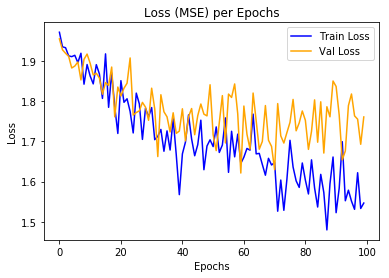

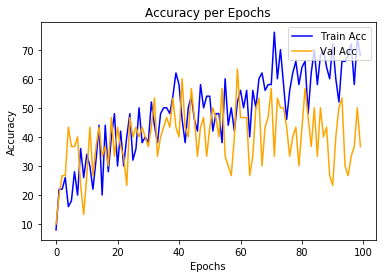

In [100]:
#stampo la perdita e l'accuracy
start_plot_index = 0

plt.plot(train_history_loss[start_plot_index:], 'blue', label='Train Loss')
plt.plot(test_history_loss[start_plot_index:], 'orange', label='Val Loss')
plt.title('Loss (MSE) per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(train_history_acc[start_plot_index:], 'blue', label='Train Acc')
plt.plot(test_history_acc[start_plot_index:], 'orange', label='Val Acc')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

## Effettua le predictions

In [101]:
#ottiene l'output dai dati di test 
res_prediction, res_output_layer = sess.run(
    [prediction, output_layer], 
    feed_dict={
      x_input1: X1_test,
      x_input2: X2_test,
      is_training: False
    })

print("Output:")
print(res_output_layer[:5])
print("Predictions:")
print(res_prediction[:5])

#trasforma gli output in predictions
predictions = np.zeros_like(res_prediction)
for i in range(len(res_prediction)):
    predictions[i, np.argmax(res_prediction[i])] = 1

print("Predictions:")
print(predictions[20:35])
print("Labels:")
print(y_test[20:35])

Output:
[[-0.77190214  2.5340514  -0.55787593  2.7156594  -3.7352445  -2.8013637
  -2.6439624 ]
 [ 4.652116    2.6274145  -2.542052   -2.2080715  -4.2324266  -4.408999
  -3.9309978 ]
 [ 3.9311125   1.647965   -0.38823295 -0.24093804 -3.5707757  -3.170784
  -3.1866083 ]
 [ 4.3934975   1.7442592  -1.3375088  -0.710049   -2.9521394  -2.801635
  -2.996139  ]
 [-0.41930896  1.3150637   2.3173697   2.0731645  -3.0652463  -3.2321627
  -2.811355  ]]
Predictions:
[[1.59856398e-02 4.36000913e-01 1.98006947e-02 5.22827864e-01
  8.25594470e-04 2.10061297e-03 2.45869393e-03]
 [8.81620646e-01 1.16403259e-01 6.62055216e-04 9.24570835e-04
  1.22116398e-04 1.02350365e-04 1.65075588e-04]
 [8.82707417e-01 9.00032893e-02 1.17475921e-02 1.36118848e-02
  4.87290672e-04 7.26946455e-04 7.15533504e-04]
 [9.24182653e-01 6.53443933e-02 2.99787475e-03 5.61455917e-03
  5.96469559e-04 6.93348527e-04 5.70794102e-04]
 [2.90574636e-02 1.64621353e-01 4.48520303e-01 3.51337999e-01
  2.06130231e-03 1.74441899e-03 2.65708

## Valuta il modello

accuracy_score: 0.4155
precision_score: 0.3483
recall_score: 0.4155
f1_score: 0.3737


C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


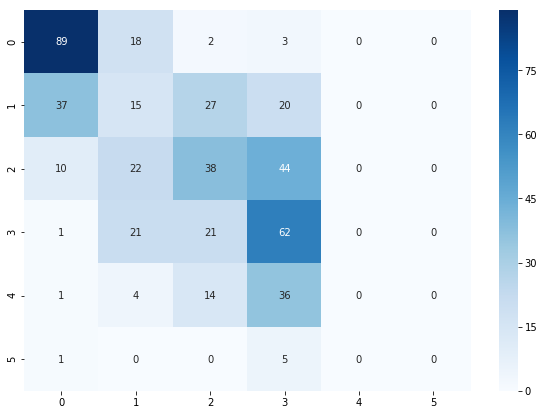

In [102]:
predictions_max = np.argmax(predictions, axis=1)
y_test_max = np.argmax(y_test, axis=1)

#calcola gli score
accuracy_score_val = accuracy_score(y_test_max, predictions_max)
precision_score_val = precision_score(y_test_max, predictions_max, average='weighted') # tp / (tp + fp)
recall_score_val = recall_score(y_test_max, predictions_max, average='weighted') # tp / (tp + fn)
f1_score_val = f1_score(y_test_max, predictions_max, average='weighted')

#stampa gli score
print("accuracy_score: %0.4f" % accuracy_score_val)
print("precision_score: %0.4f" % precision_score_val)
print("recall_score: %0.4f" % recall_score_val)
print("f1_score: %0.4f" % f1_score_val)

#ottiene e stampa la confusion matrix
categories = ('A','B','C','D','E','F','G')
cm = confusion_matrix(y_test_max, predictions_max)
df_cm = pd.DataFrame(cm, 
                     index = [i for i in range(cm.shape[1])],
                     columns = [i for i in range(cm.shape[1])])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')